In [1]:
!pip install pandas numpy scikit-learn tensorflow xgboost pymysql python-dotenv sqlalchemy boto3 sagemaker imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
import pymysql
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import boto3
from io import StringIO
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

print("Todas as bibliotecas foram importadas com sucesso!")

2024-08-30 02:31:30.556659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Todas as bibliotecas foram importadas com sucesso!


In [3]:
# Função para classificar o preço
def classify_price(price):
    if price <= 85:
        return 1
    elif price > 85 and price < 115:
        return 2
    else:
        return 3

In [4]:
# Carrega as variáveis de ambiente do arquivo .env
load_dotenv()

# Recupera as configurações de conexão das variáveis de ambiente
host = os.getenv('DB_HOST')
port = int(os.getenv('DB_PORT'))
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
database = os.getenv('DB_NAME')

# Criação do engine para conectar ao banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# Estabelece a conexão com o banco de dados
try:
    # Consulta SQL para selecionar dados da tabela desejada
    query = "SELECT * FROM base_hotel"

    # Carrega os dados no DataFrame chamado base_hotel usando o engine
    base_hotel = pd.read_sql_query(query, engine)
    
    # Exibe as primeiras linhas do DataFrame para verificar
    print(base_hotel.head())

except Exception as e:
    print(f"Erro ao conectar ou executar a consulta: {e}")

# Criar a coluna de label
base_hotel['label_avg_price_per_room'] = base_hotel['avg_price_per_room'].apply(classify_price)

# Remover a coluna avg_price_per_room
base_hotel = base_hotel.drop(columns=['avg_price_per_room'])

# Reorganizar as colunas para que 'label_avg_price_per_room' seja a primeira
columns_order = ['label_avg_price_per_room'] + [col for col in base_hotel.columns if col != 'label_avg_price_per_room']
base_hotel = base_hotel[columns_order]

# Lista de colunas que você deseja remover
colunas_para_remover = ['Booking_ID','no_of_previous_cancellations', 
                        'no_of_previous_bookings_not_canceled', 
                        'booking_status']

# Filtrar as colunas que realmente existem no DataFrame
colunas_existentes = [col for col in colunas_para_remover if col in base_hotel.columns]

# Remover colunas existentes
base_hotel.drop(columns=colunas_existentes, axis=1, inplace=True)

# Exibir o DataFrame resultante
print(base_hotel.head())


  Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_

In [5]:
from sklearn import __version__ as sklearn_version

# Tratamento de colunas categóricas usando Label Encoding
label_encoder = LabelEncoder()
base_hotel['type_of_meal_plan'] = label_encoder.fit_transform(base_hotel['type_of_meal_plan'])
base_hotel['room_type_reserved'] = label_encoder.fit_transform(base_hotel['room_type_reserved'])
base_hotel['market_segment_type'] = label_encoder.fit_transform(base_hotel['market_segment_type'])

# Aplicar One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
meal_plan_encoded = one_hot_encoder.fit_transform(base_hotel[['type_of_meal_plan']])
meal_plan_df = pd.DataFrame(meal_plan_encoded, columns=one_hot_encoder.get_feature_names_out(['type_of_meal_plan']))
base_hotel = pd.concat([base_hotel, meal_plan_df], axis=1)
base_hotel.drop(['type_of_meal_plan'], axis=1, inplace=True)

# Imputação de valores faltantes
imputer = SimpleImputer(strategy='mean')
base_hotel[['label_avg_price_per_room']] = imputer.fit_transform(base_hotel[['label_avg_price_per_room']])

# Convertendo valores para inteiros
base_hotel['label_avg_price_per_room'] = base_hotel['label_avg_price_per_room'].astype(int)

# Tratamento de colunas de data
base_hotel['arrival_date'] = base_hotel['arrival_date'].astype(int)
base_hotel['arrival_month'] = base_hotel['arrival_month'].astype(int)
base_hotel['arrival_year'] = base_hotel['arrival_year'].astype(int)

# Remoção de colunas redundantes se houver
base_hotel.drop_duplicates(inplace=True)

# Aplicar One-Hot Encoding para variáveis categóricas restantes
base_hotel_encoded = pd.get_dummies(base_hotel, columns=['required_car_parking_space', 'room_type_reserved', 'arrival_year', 'arrival_month', 'no_of_special_requests'])

# Extrair as features (X) e o target (Y) do DataFrame codificado
X = base_hotel_encoded.drop(columns=['label_avg_price_per_room']).values  # Features (excluindo o target)
Y = base_hotel_encoded['label_avg_price_per_room'].values  # Target

# Codificar o target Y para inteiros consecutivos
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Dividir o conjunto de dados em treinamento e teste
X_treinamento, X_teste, Y_treinamento, Y_teste = train_test_split(X, Y_encoded, test_size=0.3, random_state=1, stratify=Y_encoded)

# Exibir o DataFrame codificado
print("DataFrame codificado:")
print(base_hotel_encoded.head())

# Exibir as dimensões dos conjuntos de dados
print(f"Dimensões do conjunto de treinamento: {X_treinamento.shape}, {Y_treinamento.shape}")
print(f"Dimensões do conjunto de teste: {X_teste.shape}, {Y_teste.shape}")

DataFrame codificado:
   label_avg_price_per_room  no_of_adults  no_of_children  \
0                         1             2               0   
1                         2             2               0   
2                         1             1               0   
3                         2             2               0   
4                         2             2               0   

   no_of_weekend_nights  no_of_week_nights  lead_time  arrival_date  \
0                     1                  2        224             2   
1                     2                  3          5             6   
2                     2                  1          1            28   
3                     0                  2        211            20   
4                     1                  1         48            11   

   market_segment_type  repeated_guest  type_of_meal_plan_1  ...  \
0                    3               0                  0.0  ...   
1                    4               0          

In [6]:
# Normalização dos dados
scaler = StandardScaler()
X_treinamento = scaler.fit_transform(X_treinamento)
X_teste = scaler.transform(X_teste)

# Exibir o DataFrame codificado
print("DataFrame codificado:")
print(base_hotel_encoded.head())

# Nome da nova tabela
table_name = 'base_hotel_modified3'

# Salvar o DataFrame em uma nova tabela no banco de dados
base_hotel.to_sql(name=table_name, con=engine, if_exists='replace', index=False)
print(f"Tabela '{table_name}' criada e salva com sucesso no banco de dados.")


DataFrame codificado:
   label_avg_price_per_room  no_of_adults  no_of_children  \
0                         1             2               0   
1                         2             2               0   
2                         1             1               0   
3                         2             2               0   
4                         2             2               0   

   no_of_weekend_nights  no_of_week_nights  lead_time  arrival_date  \
0                     1                  2        224             2   
1                     2                  3          5             6   
2                     2                  1          1            28   
3                     0                  2        211            20   
4                     1                  1         48            11   

   market_segment_type  repeated_guest  type_of_meal_plan_1  ...  \
0                    3               0                  0.0  ...   
1                    4               0          

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos das classes
class_weights = compute_class_weight('balanced', classes=np.unique(Y_encoded), y=Y_encoded)
class_weights_dict = dict(enumerate(class_weights))

print(f"Pesos das classes: {class_weights_dict}")

# Construir o modelo de Redes Neurais Profundas
model = Sequential()

# Camada de entrada
model.add(Dense(128, input_shape=(X_treinamento.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Aumentar o dropout para combater overfitting

# Camada oculta 1
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Aumentar o dropout para combater overfitting

# Camada oculta 2
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Aumentar o dropout para combater overfitting

# Camada oculta 3 (adicional)
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Aumentar o dropout para combater overfitting

# Camada de saída
num_classes = len(np.unique(Y_encoded))  # Ajuste o número de classes conforme necessário
model.add(Dense(num_classes, activation='softmax'))

# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.0005),  # Reduzir a taxa de aprendizado
              loss='sparse_categorical_crossentropy',  # Usar 'sparse_categorical_crossentropy' para classes inteiras
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


Pesos das classes: {0: 1.1297330850403475, 1: 0.9549509032306424, 2: 0.9366269666225555}


In [16]:
# Treinar o modelo
history = model.fit(
    X_treinamento, Y_treinamento,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Usando validação interna
    callbacks=[early_stopping]
)

# Fazer previsões
Y_pred = model.predict(X_teste)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Decodificar os rótulos para os rótulos originais
Y_pred_decoded = label_encoder.inverse_transform(Y_pred_classes)
Y_teste_decoded = label_encoder.inverse_transform(Y_teste)

# Avaliar o modelo
accuracy = accuracy_score(Y_teste_decoded, Y_pred_decoded)
print("DNN Accuracy Score:", accuracy)
print("DNN Classification Report:\n", classification_report(Y_teste_decoded, Y_pred_decoded))

Epoch 1/100
223/223 [==============================] - 5s 9ms/step - loss: 1.2671 - accuracy: 0.3943 - val_loss: 0.9667 - val_accuracy: 0.5266
Epoch 2/100
223/223 [==============================] - 1s 6ms/step - loss: 1.0286 - accuracy: 0.4829 - val_loss: 0.8606 - val_accuracy: 0.5743
Epoch 3/100
223/223 [==============================] - 1s 6ms/step - loss: 0.9229 - accuracy: 0.5487 - val_loss: 0.7936 - val_accuracy: 0.6334
Epoch 4/100
223/223 [==============================] - 1s 5ms/step - loss: 0.8663 - accuracy: 0.5931 - val_loss: 0.7511 - val_accuracy: 0.6707
Epoch 5/100
223/223 [==============================] - 1s 6ms/step - loss: 0.8276 - accuracy: 0.6115 - val_loss: 0.7261 - val_accuracy: 0.6777
Epoch 6/100
223/223 [==============================] - 1s 5ms/step - loss: 0.8046 - accuracy: 0.6285 - val_loss: 0.7103 - val_accuracy: 0.6811
Epoch 7/100
223/223 [==============================] - 1s 4ms/step - loss: 0.7803 - accuracy: 0.6468 - val_loss: 0.6977 - val_accuracy: 0.6883

In [17]:
# Avaliar o modelo nos dados de teste
test_loss, test_accuracy = model.evaluate(X_teste, Y_teste)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

239/239 [==============================] - 1s 2ms/step - loss: 0.5856 - accuracy: 0.7534
Test Accuracy: 75.34%


In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Calcular pesos das classes
class_weights = compute_class_weight('balanced', classes=np.unique(Y_encoded), y=Y_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Aplicar SMOTE para reamostragem
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_treinamento, Y_treinamento)

# Normalização dos dados
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_teste = scaler.transform(X_teste)

# Construir o modelo de Redes Neurais Profundas
model = Sequential()
model.add(Dense(128, input_shape=(X_resampled.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
num_classes = len(np.unique(Y_encoded))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinar o modelo
history = model.fit(
    X_resampled, Y_resampled,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Obter as previsões do modelo de rede neural
Y_pred_nn = model.predict(X_teste)
Y_pred_nn_classes = np.argmax(Y_pred_nn, axis=1)

# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Ajustar o número de vizinhos conforme necessário
knn.fit(X_resampled, Y_resampled)

# Obter previsões do modelo KNN
Y_pred_knn = knn.predict(X_teste)

# Comparar o desempenho dos modelos
accuracy_nn = accuracy_score(Y_teste, Y_pred_nn_classes)
accuracy_knn = accuracy_score(Y_teste, Y_pred_knn)

print("DNN Accuracy Score:", accuracy_nn)
print("KNN Accuracy Score:", accuracy_knn)

print("DNN Classification Report:\n", classification_report(Y_teste, Y_pred_nn_classes))
print("KNN Classification Report:\n", classification_report(Y_teste, Y_pred_knn))

Epoch 1/100
238/238 [==============================] - 4s 6ms/step - loss: 1.6021 - accuracy: 0.3637 - val_loss: 1.0360 - val_accuracy: 0.4159
Epoch 2/100
238/238 [==============================] - 1s 4ms/step - loss: 1.2383 - accuracy: 0.4165 - val_loss: 0.9195 - val_accuracy: 0.5750
Epoch 3/100
238/238 [==============================] - 1s 4ms/step - loss: 1.0581 - accuracy: 0.4756 - val_loss: 0.8449 - val_accuracy: 0.6180
Epoch 4/100
238/238 [==============================] - 1s 4ms/step - loss: 0.9569 - accuracy: 0.5227 - val_loss: 0.7866 - val_accuracy: 0.6461
Epoch 5/100
238/238 [==============================] - 1s 4ms/step - loss: 0.8975 - accuracy: 0.5565 - val_loss: 0.7468 - val_accuracy: 0.6705
Epoch 6/100
238/238 [==============================] - 1s 4ms/step - loss: 0.8503 - accuracy: 0.5848 - val_loss: 0.7180 - val_accuracy: 0.6910
Epoch 7/100
238/238 [==============================] - 1s 6ms/step - loss: 0.8222 - accuracy: 0.6098 - val_loss: 0.7001 - val_accuracy: 0.6957

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Assumindo que já temos o KNN e DNN treinados

# Fazer previsões com o KNN
knn_prob = knn.predict_proba(X_teste)

# Fazer previsões com o DNN
dnn_prob = model.predict(X_teste)

# Combinar as previsões usando uma média ponderada (ajuste os pesos conforme necessário)
combined_prob = (0.5 * knn_prob) + (0.5 * dnn_prob)

# Obter previsões finais
Y_pred_combined = np.argmax(combined_prob, axis=1)

# Avaliar o modelo combinado
print("Combined Model Accuracy Score:", accuracy_score(Y_teste, Y_pred_combined))
print("Combined Model Classification Report:\n", classification_report(Y_teste, Y_pred_combined))

239/239 [==============================] - 0s 1ms/step
Combined Model Accuracy Score: 0.7579801151229723
Combined Model Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      2255
           1       0.68      0.69      0.69      2668
           2       0.79      0.85      0.82      2721

    accuracy                           0.76      7644
   macro avg       0.76      0.76      0.76      7644
weighted avg       0.76      0.76      0.76      7644



239/239 [==============================] - 0s 2ms/step
F1-Score: 0.7675
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      2255
           1       0.69      0.70      0.70      2668
           2       0.82      0.84      0.83      2721

    accuracy                           0.77      7644
   macro avg       0.77      0.77      0.77      7644
weighted avg       0.77      0.77      0.77      7644



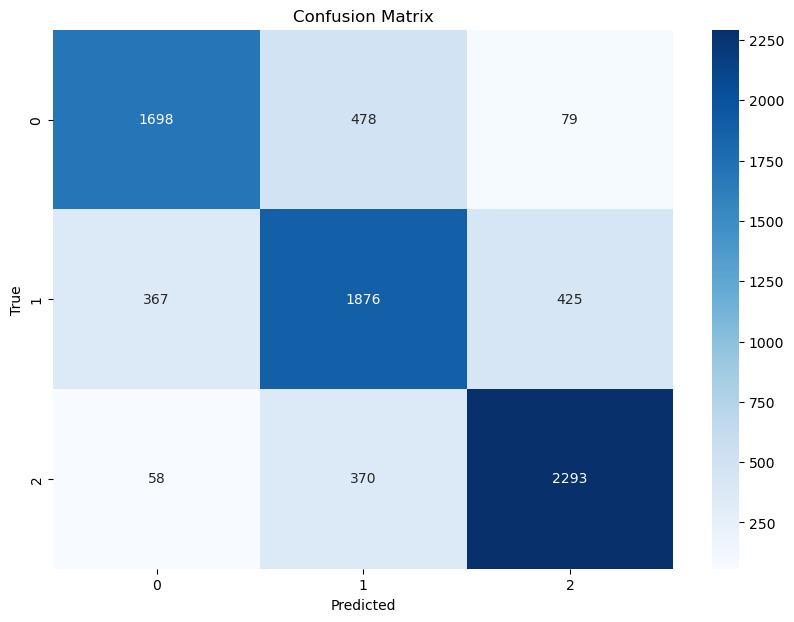

In [12]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Previsões no conjunto de teste
y_pred = model.predict(X_teste)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes

# Calcular o F1-Score
f1 = f1_score(Y_teste, y_pred_classes, average='weighted')
print(f'F1-Score: {f1:.4f}')

# Relatório de classificação detalhado
report = classification_report(Y_teste, y_pred_classes, target_names=[str(i) for i in np.unique(Y_encoded)])
print("Classification Report:")
print(report)

# Matriz de confusão
conf_matrix = confusion_matrix(Y_teste, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in np.unique(Y_encoded)],
            yticklabels=[str(i) for i in np.unique(Y_encoded)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
import joblib
import pickle
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.model import Model
import tensorflow as tf
import os

# Definindo o nome do bucket e o caminho do modelo
bucket_name = "s3sagemakermo"
model_path = "model"
saved_model_path = "saved_model"

# Salvar o modelo TensorFlow
model.save(saved_model_path)
print(f"Modelo TensorFlow salvo no caminho: {saved_model_path}")

# Salvar o modelo em formato .pkl
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Modelo salvo como model.pkl")

# Salvar o modelo em formato .joblib
joblib.dump(model, 'model.joblib')
print("Modelo salvo como model.joblib")

# Configurar boto3 para o upload no S3
s3 = boto3.client('s3')

# Fazer o upload do modelo para o bucket S3
def upload_to_s3(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = file_name
    s3.upload_file(file_name, bucket, object_name)
    print(f"{file_name} foi carregado para o bucket {bucket} com o nome {object_name}")

# Carregar os arquivos para o bucket S3
upload_to_s3('model.pkl', bucket_name)
upload_to_s3('model.joblib', bucket_name)

# Salvar o modelo TensorFlow no S3
def upload_directory_to_s3(local_directory, bucket_name, s3_directory):
    for root, dirs, files in os.walk(local_directory):
        for file in files:
            local_file = os.path.join(root, file)
            s3_file = os.path.join(s3_directory, file)
            s3.upload_file(local_file, bucket_name, s3_file)
            print(f"{local_file} foi carregado para o bucket {bucket_name} com o nome {s3_file}")

upload_directory_to_s3(saved_model_path, bucket_name, 'saved_model')

print("Todos os arquivos foram carregados para o S3 com sucesso!")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Modelo TensorFlow salvo no caminho: saved_model
Modelo salvo como model.pkl
Modelo salvo como model.joblib
model.pkl foi carregado para o bucket s3sagemakermo com o nome model.pkl
model.joblib foi carregado para o bucket s3sagemakermo com o nome model.joblib
saved_model/saved_model.pb foi carregado para o bucket s3sagemakermo com o nome saved_model/saved_model.pb
saved_model/fingerprint.pb foi carregado para o bucket s3sagemakermo com o nome saved_model/fingerprint.pb
saved_model/keras_metadata.pb foi carregado para o bucket s3sagemakermo com o nome saved_model/keras_metadata.pb
saved_model/variables/variables.data-00000-of-00001 foi carregado para o bucket s3sagemakermo com o nome saved_model/variables.data-00000-of-00001
saved_model/variables/variables.index foi carregado para o bucket s3sagemakermo com o nome saved_model/variables.index
Todos os arquivos foram carregados para o S3 com sucesso!
